# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

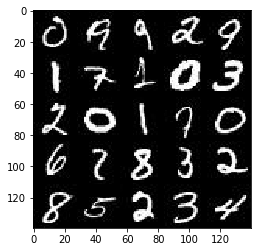

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

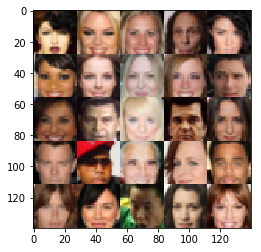

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_image")
    z_data = tf.placeholder(tf.float32, [None, z_dim], name="z_data")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return real_image, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
alpha = 0.2

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #input 28*28*3
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 14*14*64
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        leaky_relu1 = tf.maximum(alpha * layer1, layer1)
    
        # 7*7*128
        layer2 = tf.layers.conv2d(leaky_relu1, 128, 5, strides=2, padding='same')
        batch_normalized2 = tf.layers.batch_normalization(layer2, training=True)
        leaky_relu2 = tf.maximum(alpha * batch_normalized2, batch_normalized2)

        # 4*4*256
        layer3 = tf.layers.conv2d(leaky_relu2, 256, 5, strides=2, padding='same')
        batch_normalized3 = tf.layers.batch_normalization(layer3, training=True)
        leaky_relu3 = tf.maximum(alpha * batch_normalized3, batch_normalized3)

#         # 2*2*1024
#         layer4 = tf.layers.conv2d(leaky_relu3, 1024, 5, strides=2, padding='same')
#         batch_normalized4 = tf.layers.batch_normalization(layer4, training=True)
#         leaky_relu4 = tf.maximum(alpha * batch_normalized4, batch_normalized4)

        flattened = tf.reshape(batch_normalized3, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):

        layer_to_flatten = tf.layers.dense(z, 4*4*512)

        # 4*4*512
        flattened_layer = tf.reshape(layer_to_flatten, (-1, 4, 4, 512))
        batch_normalized1 = tf.layers.batch_normalization(flattened_layer, training=is_train)
        leaky_relu1 = tf.maximum(alpha * batch_normalized1, batch_normalized1)

        # 7*7*256
        layer2 = tf.layers.conv2d_transpose(leaky_relu1, 256, 4, strides=1, padding='valid')
        batch_normalized2 = tf.layers.batch_normalization(layer2, training=is_train)
        leaky_relu2 = tf.maximum(alpha * batch_normalized2, batch_normalized2)

        #14*14*128
        layer3 = tf.layers.conv2d_transpose(leaky_relu2, 128, 5, strides=2, padding='same')
        batch_normalized3 = tf.layers.batch_normalization(layer3, training=is_train)
        leaky_relu3 = tf.maximum(alpha * batch_normalized3, batch_normalized3)
        
        # Output layer - 28*28*3
        logits = tf.layers.conv2d_transpose(leaky_relu3, out_channel_dim, 5, strides=2, padding='same')
                
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
smooth = 0.1

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake))
    )

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)    
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_opt, g_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     def model_inputs(image_width, image_height, image_channels, z_dim):
#         """
#         Create the model inputs
#         :param image_width: The input image width
#         :param image_height: The input image height
#         :param image_channels: The number of image channels
#         :param z_dim: The dimension of Z
#         :return: Tuple of (tensor of real input images, tensor of z data, learning rate)

# TODO: Build Model
#    out_channel_dim = 3 if data_image_mode == "RGB" else 1
    
    input_real, input_z, tf_learning_rate = model_inputs(*data_shape[1:], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])

    d_opt, g_opt = model_opt(d_loss, g_loss, tf_learning_rate, beta1)    
    
    step = 0
    display_every = 50
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print("epoch_i = ", epoch_i)
            for batch_images in get_batches(batch_size):
                step += 1
                
                batch_images = batch_images * 2
                
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(
                    d_opt, feed_dict={input_real: batch_images, input_z: batch_z, tf_learning_rate: learning_rate}
                )
                _ = sess.run(
                    g_opt, feed_dict={input_real: batch_images, input_z: batch_z, tf_learning_rate: learning_rate}
                )
                _ = sess.run(
                    g_opt, feed_dict={input_real: batch_images, input_z: batch_z, tf_learning_rate: learning_rate}
                )
#                 _ = sess.run(
#                     g_opt, feed_dict={input_real: batch_images, input_z: batch_z, tf_learning_rate: learning_rate}
#                 )
                
                if step % display_every == 0:
                    print("step = ", step)
                    d_loss_sample = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_loss_sample = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_sample),
                          "Generator Loss: {:.4f}".format(g_loss_sample))

                    show_generator_output(sess, 25, input_z, data_shape[-1], data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch_i =  0
step =  50
Epoch 1/2... Discriminator Loss: 1.7059... Generator Loss: 1.6449


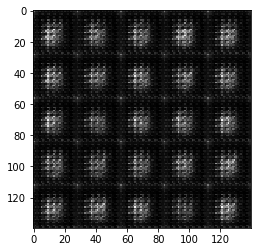

step =  100
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 1.1288


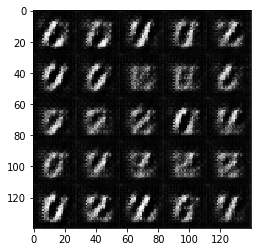

step =  150
Epoch 1/2... Discriminator Loss: 1.6655... Generator Loss: 0.6751


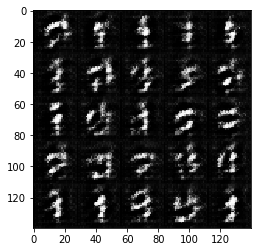

step =  200
Epoch 1/2... Discriminator Loss: 1.4882... Generator Loss: 0.8092


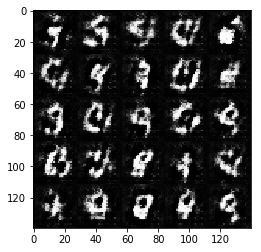

step =  250
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.7734


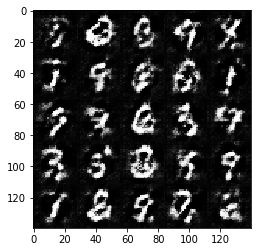

step =  300
Epoch 1/2... Discriminator Loss: 1.7607... Generator Loss: 0.3422


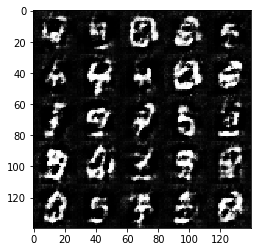

step =  350
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 0.6306


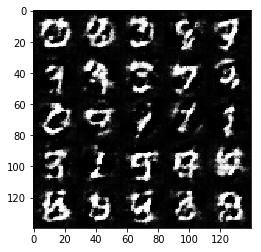

step =  400
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.4429


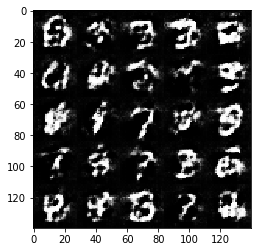

step =  450
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 1.2081


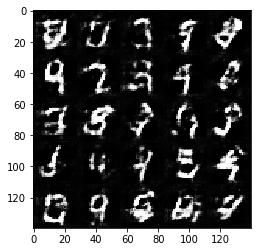

step =  500
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.6210


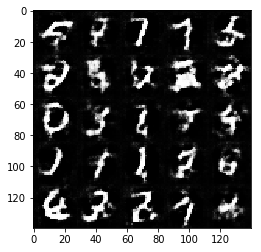

step =  550
Epoch 1/2... Discriminator Loss: 1.4949... Generator Loss: 0.6855


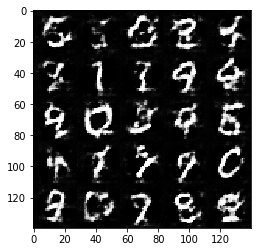

step =  600
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.4946


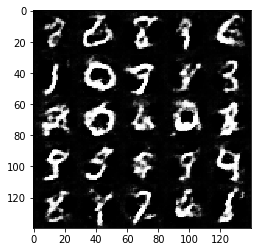

step =  650
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.8378


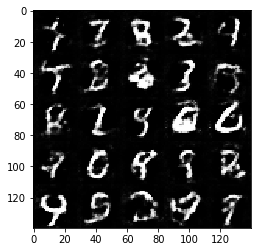

step =  700
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 0.5529


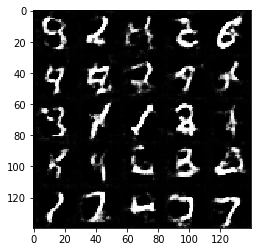

step =  750
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.7456


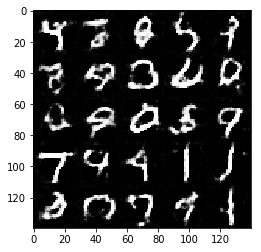

step =  800
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.7694


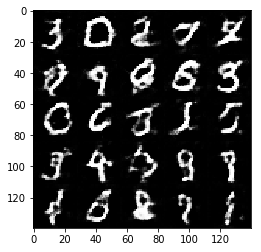

step =  850
Epoch 1/2... Discriminator Loss: 1.5715... Generator Loss: 0.4760


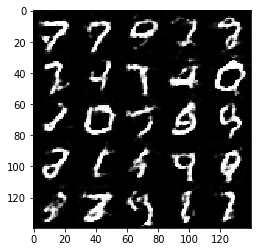

step =  900
Epoch 1/2... Discriminator Loss: 1.6711... Generator Loss: 0.3511


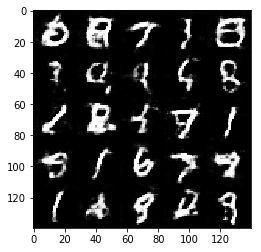

epoch_i =  1
step =  950
Epoch 2/2... Discriminator Loss: 1.4473... Generator Loss: 1.0851


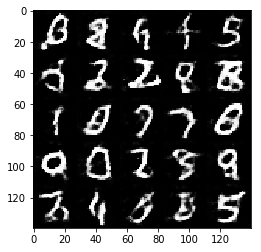

step =  1000
Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.5758


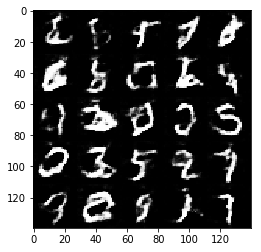

step =  1050
Epoch 2/2... Discriminator Loss: 1.6903... Generator Loss: 0.3215


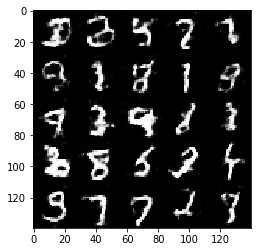

step =  1100
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.9805


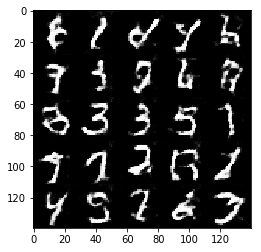

step =  1150
Epoch 2/2... Discriminator Loss: 2.0702... Generator Loss: 0.2275


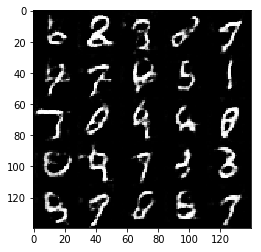

step =  1200
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.6185


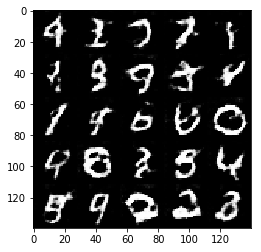

step =  1250
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.6158


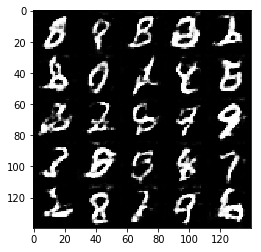

step =  1300
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.6301


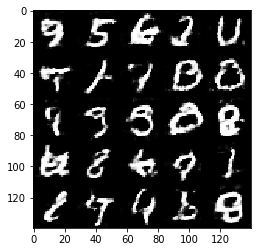

step =  1350
Epoch 2/2... Discriminator Loss: 3.2022... Generator Loss: 0.0730


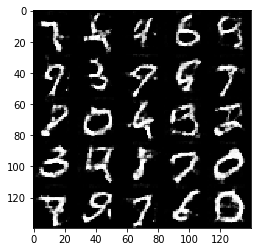

step =  1400
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 1.1065


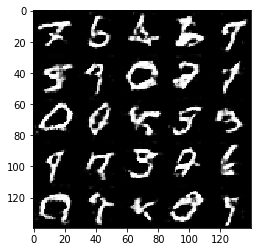

step =  1450
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.4854


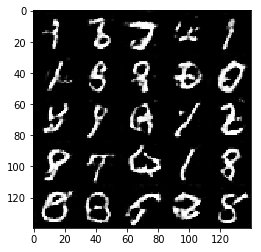

step =  1500
Epoch 2/2... Discriminator Loss: 1.5706... Generator Loss: 0.3708


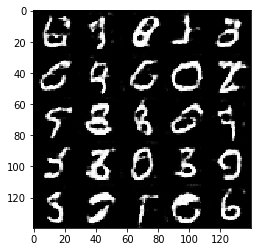

step =  1550
Epoch 2/2... Discriminator Loss: 1.5264... Generator Loss: 0.4087


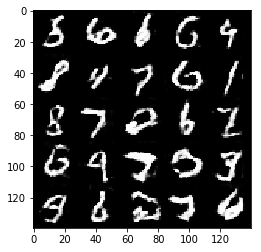

step =  1600
Epoch 2/2... Discriminator Loss: 1.3428... Generator Loss: 0.5826


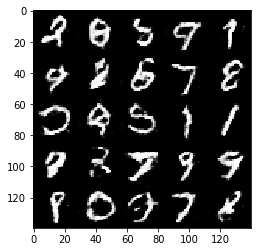

step =  1650
Epoch 2/2... Discriminator Loss: 1.6025... Generator Loss: 0.3614


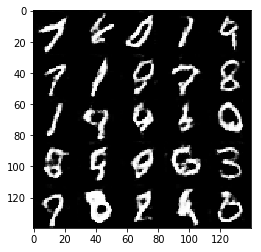

step =  1700
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 1.1822


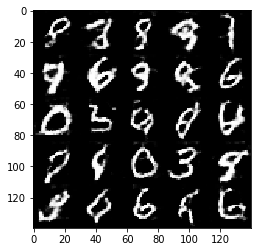

step =  1750
Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 0.7991


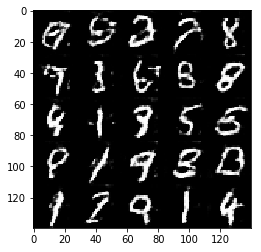

step =  1800
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 0.8986


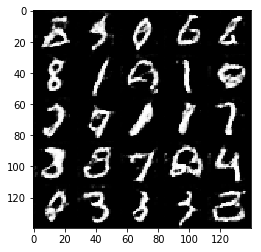

step =  1850
Epoch 2/2... Discriminator Loss: 2.6009... Generator Loss: 1.3675


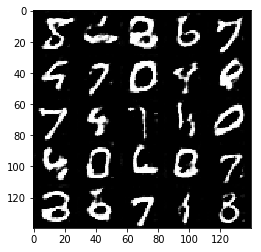

In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2


#tf.reset_default_graph()
    
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch_i =  0
step =  50
Epoch 1/1... Discriminator Loss: 2.3197... Generator Loss: 1.2102


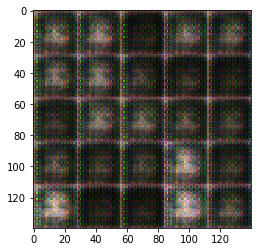

step =  100
Epoch 1/1... Discriminator Loss: 1.7070... Generator Loss: 0.7253


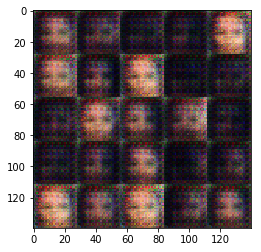

step =  150
Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 0.5249


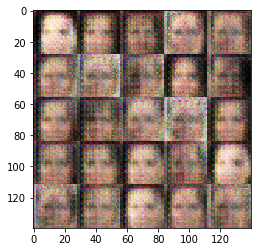

step =  200
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.6797


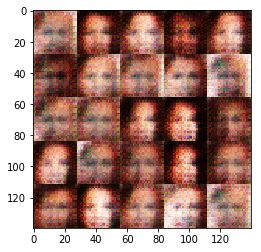

step =  250
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.5858


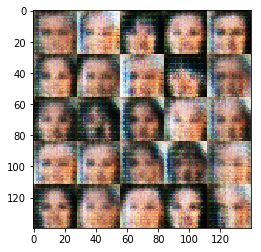

step =  300
Epoch 1/1... Discriminator Loss: 1.6259... Generator Loss: 0.6011


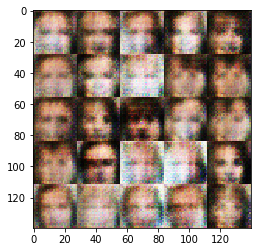

step =  350
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.6990


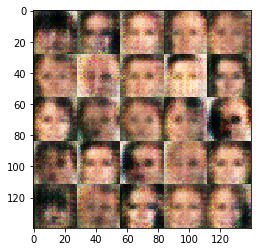

step =  400
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.8073


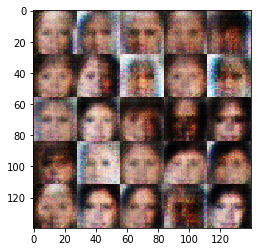

step =  450
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7266


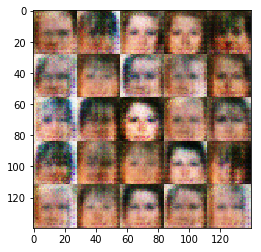

step =  500
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.6567


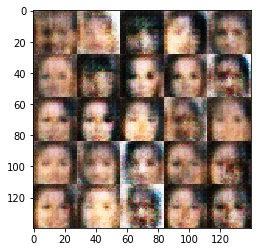

step =  550
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.6208


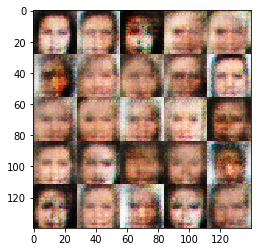

step =  600
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6886


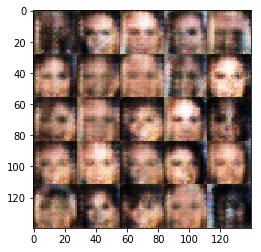

step =  650
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.7423


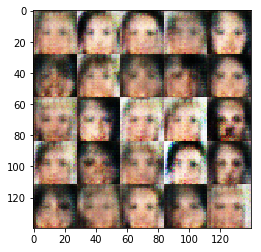

step =  700
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.9328


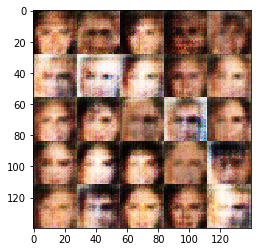

step =  750
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7091


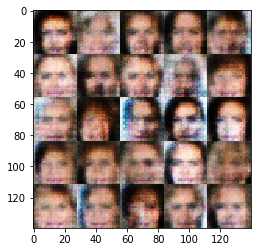

step =  800
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.9272


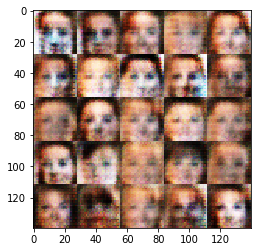

step =  850
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.8416


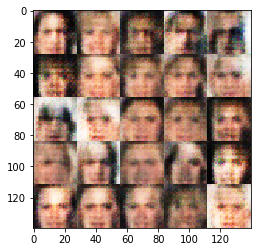

step =  900
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7409


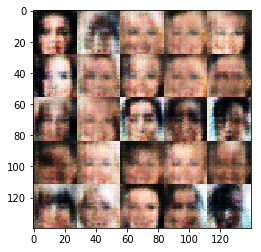

step =  950
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6931


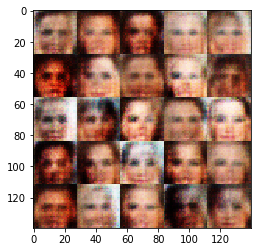

step =  1000
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6104


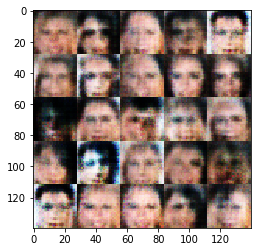

step =  1050
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6439


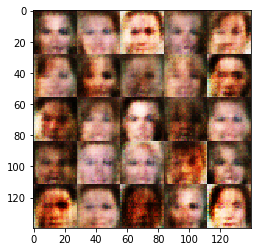

step =  1100
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.8847


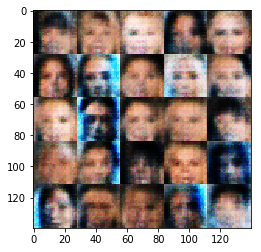

step =  1150
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.7489


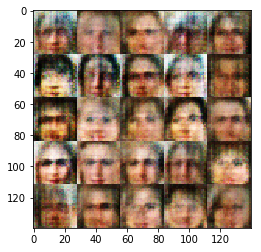

step =  1200
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6893


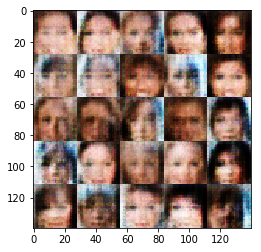

step =  1250
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.7155


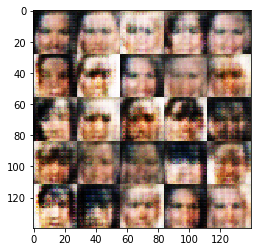

step =  1300
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7649


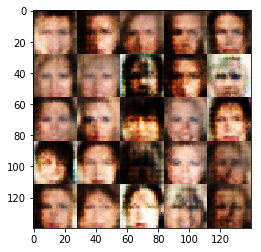

step =  1350
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.7005


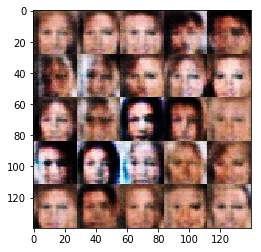

step =  1400
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.7227


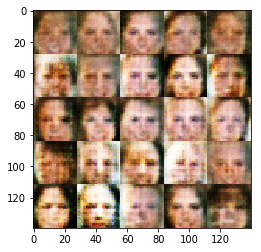

step =  1450
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.8076


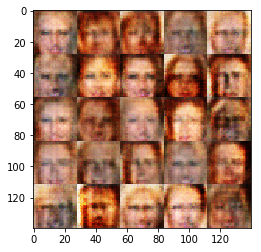

step =  1500
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.5008


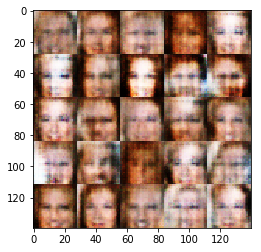

step =  1550
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.9450


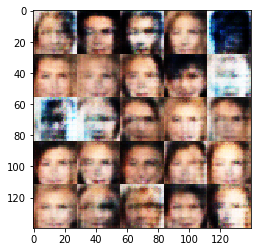

step =  1600
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7785


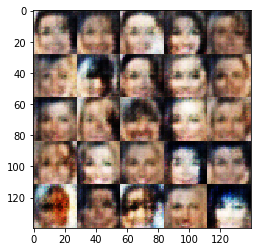

step =  1650
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.8002


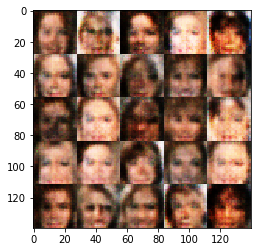

step =  1700
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7217


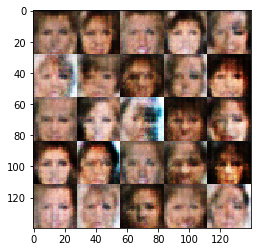

step =  1750
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.6821


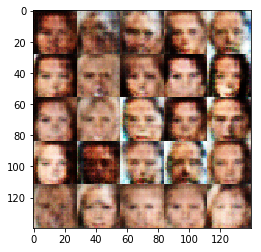

step =  1800
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7987


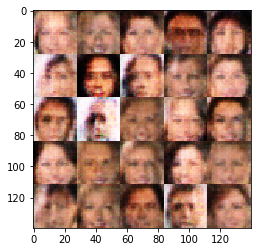

step =  1850
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.9519


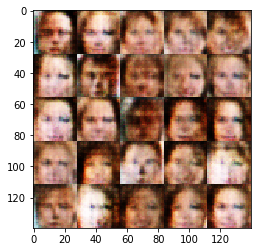

step =  1900
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7033


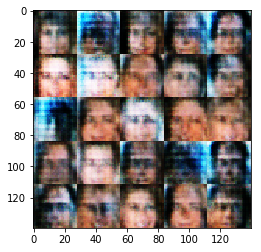

step =  1950
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.8665


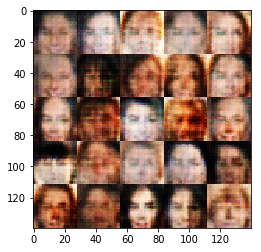

step =  2000
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7947


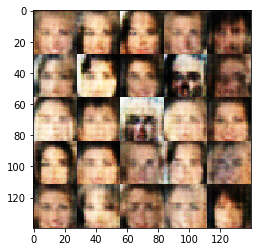

step =  2050
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7925


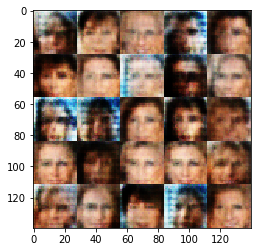

step =  2100
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8024


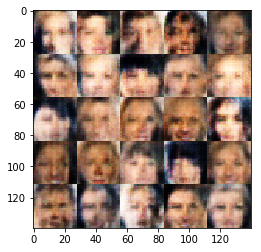

step =  2150
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.9003


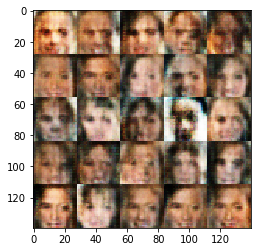

step =  2200
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.8397


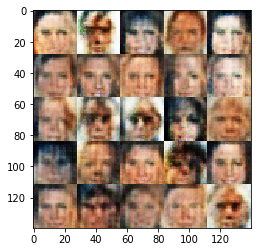

step =  2250
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7524


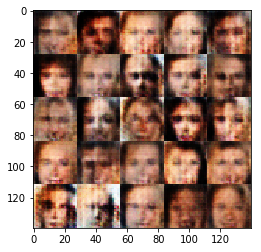

step =  2300
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.9192


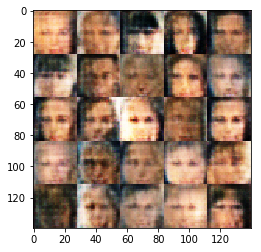

step =  2350
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.6601


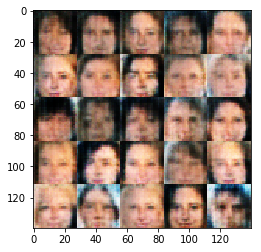

step =  2400
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.7862


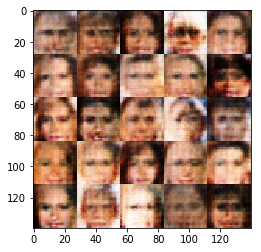

step =  2450
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7884


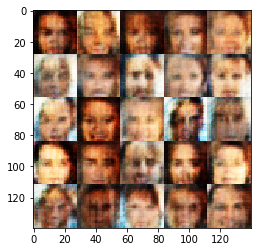

step =  2500
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.9072


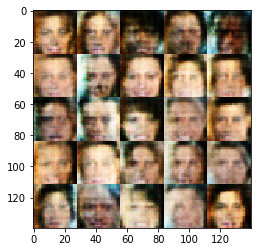

step =  2550
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7974


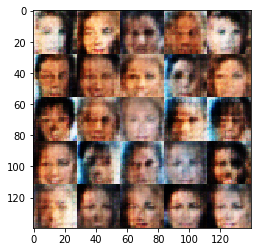

step =  2600
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.8885


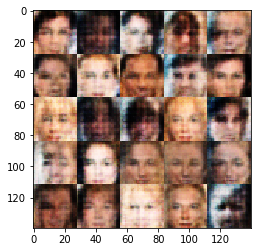

step =  2650
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.8537


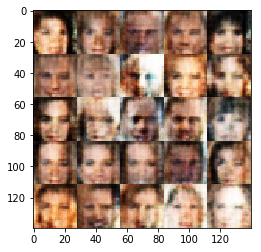

step =  2700
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7617


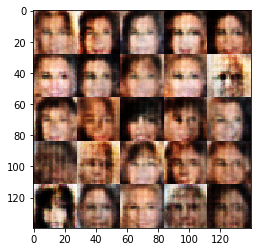

step =  2750
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7874


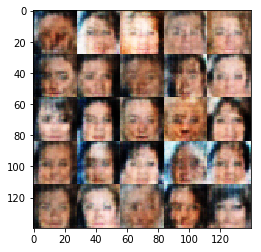

step =  2800
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7187


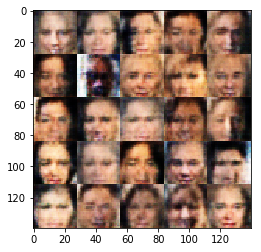

step =  2850
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6432


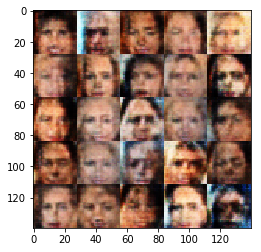

step =  2900
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6568


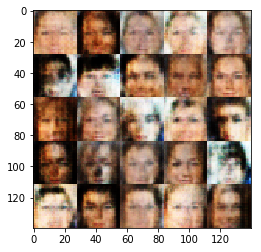

step =  2950
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7635


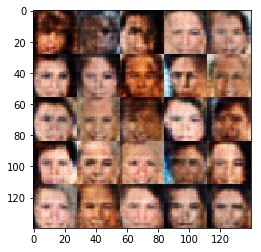

step =  3000
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7888


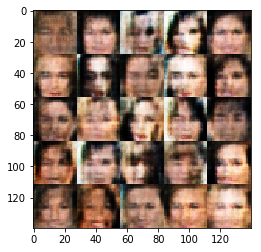

step =  3050
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.9488


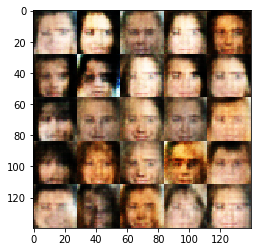

step =  3100
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7206


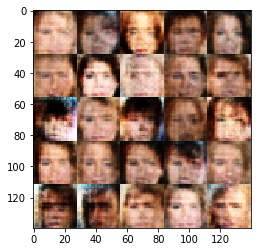

step =  3150
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6938


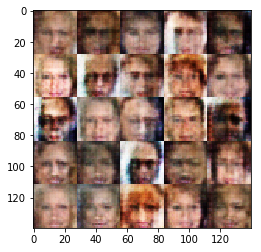

In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.